In [1]:
import pandas
import os
import matplotlib.pyplot as plt
import re
from pathlib import Path
import json

In [2]:
result_dir = "eval-results"
result_naming = "{method}-F{frozen_layers}-T{task_layers}-aug{aug_size}-bf16{bf16}-merged_T{temp}_P{top_p}_evaluation.json"

In [3]:
speed = {'multi-task': {}, 'lora': {}}
def extract_numbers_from_txts(directory: Path):
    txt_files = directory.glob("*.txt")
    number_pattern = re.compile(r"Avg generation throughput:\s*([0-9]+(?:\.[0-9]+)?)\s+tokens/s")

    for txt_file in txt_files:
        text = txt_file.read_text(encoding="utf-8")
        numbers = number_pattern.findall(text)[:-1]
        average = sum(map(float, numbers)) / len(numbers) if numbers else 0
        print(f"{txt_file.name}: {average}")
        if 'mt' in txt_file.name:
            name = txt_file.name
            layers = int(name.split('vllm_mt_f')[1].split("_")[0])   
            speed['multi-task'][layers+2] = average
        else:
            name = txt_file.name
            layers = int(name.split('vllm_lora_f')[1].split("_")[0])   
            speed['lora'][layers] = average


if __name__ == "__main__":
    base_dir = Path("eval-results/inference-log")
    extract_numbers_from_txts(base_dir)

vllm_lora_f30_t0_aug1.0_bf161_temp0.7_topp0.9.txt: 748.4760563380281
vllm_mt_f28_t2_aug1.0_bf160_temp0.7_topp0.9.txt: 746.7234374999998
vllm_mt_f14_t2_aug1.0_bf160_temp0.7_topp0.9.txt: 1170.1899999999998
vllm_lora_f8_t0_aug1.0_bf161_temp0.7_topp0.9.txt: 1766.204166666667
vllm_mt_f6_t2_aug1.0_bf160_temp0.7_topp0.9.txt: 1742.3142857142857
vllm_lora_f24_t0_aug1.0_bf161_temp0.7_topp0.9.txt: 821.1129032258066
vllm_lora_f16_t0_aug1.0_bf161_temp0.7_topp0.9.txt: 1162.8461538461538
vllm_mt_f22_t2_aug1.0_bf160_temp0.7_topp0.9.txt: 852.0000000000003


In [4]:
speed

{'multi-task': {30: 746.7234374999998,
  16: 1170.1899999999998,
  8: 1742.3142857142857,
  24: 852.0000000000003},
 'lora': {30: 748.4760563380281,
  8: 1766.204166666667,
  24: 821.1129032258066,
  16: 1162.8461538461538}}

In [5]:
results = {}
results['multi-task'] = {}
for frozen_layers in [6, 14, 22, 28]:
    name = result_naming.format(
        method="leobitz_MultiTask",
        frozen_layers=frozen_layers,
        task_layers=2,
        aug_size=1.0,
        bf16=0,
        temp=0.0,
        top_p=1.0
    )
    path = os.path.join(result_dir, name)
    vals = json.loads(open(path, "r").read())
    frozen_layers = frozen_layers + 2
    results['multi-task'][frozen_layers]= {}
    for dataset_name in vals.keys():
        if 'scientific_papers_en_es' in dataset_name or 'all' in dataset_name:
            continue
        results['multi-task'][frozen_layers][dataset_name] = vals[dataset_name]['sacrebleu']
    results['multi-task'][frozen_layers]['average'] = sum(results['multi-task'][frozen_layers].values()) / len(results['multi-task'][frozen_layers])

results['lora'] = {}
for frozen_layers in [8, 16, 24, 30]:
    name = result_naming.format(
        method="leobitz_LoRA",
        frozen_layers=frozen_layers,
        task_layers=0,
        aug_size=1.0,
        bf16=1,
        temp=0.0,
        top_p=1.0
    )
    path = os.path.join(result_dir, name)
    vals = json.loads(open(path, "r").read())
    results['lora'][frozen_layers]= {}
    for dataset_name in vals.keys():
        if 'scientific_papers_en_es' in dataset_name or 'all' in dataset_name:
            continue
        results['lora'][frozen_layers][dataset_name] = vals[dataset_name]['sacrebleu']
    results['lora'][frozen_layers]['average'] = sum(results['lora'][frozen_layers].values()) / len(results['lora'][frozen_layers])

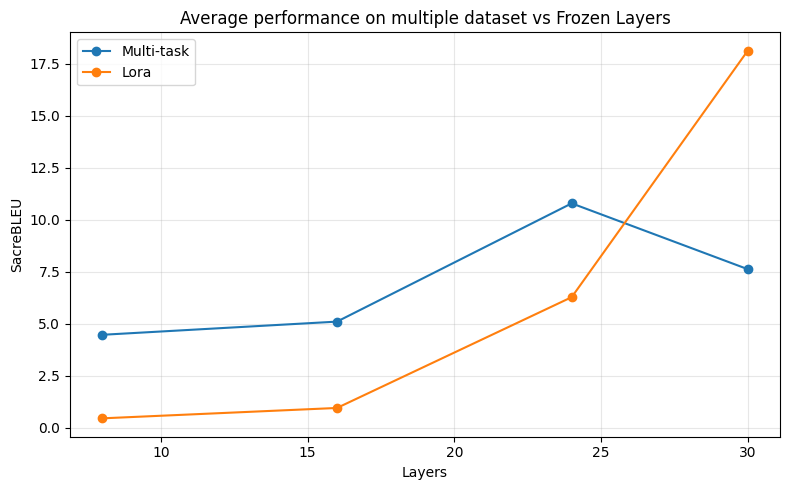

In [6]:
plt.figure(figsize=(8, 5))
for method in ("multi-task", "lora"):
    frozen_order = sorted(results[method])
    scores = [results[method][layers]['average'] for layers in frozen_order]
    plt.plot(frozen_order, scores, marker="o", label=method.capitalize())

plt.title(f"Average performance on multiple dataset vs Frozen Layers")
plt.xlabel("Layers")
plt.ylabel("SacreBLEU")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

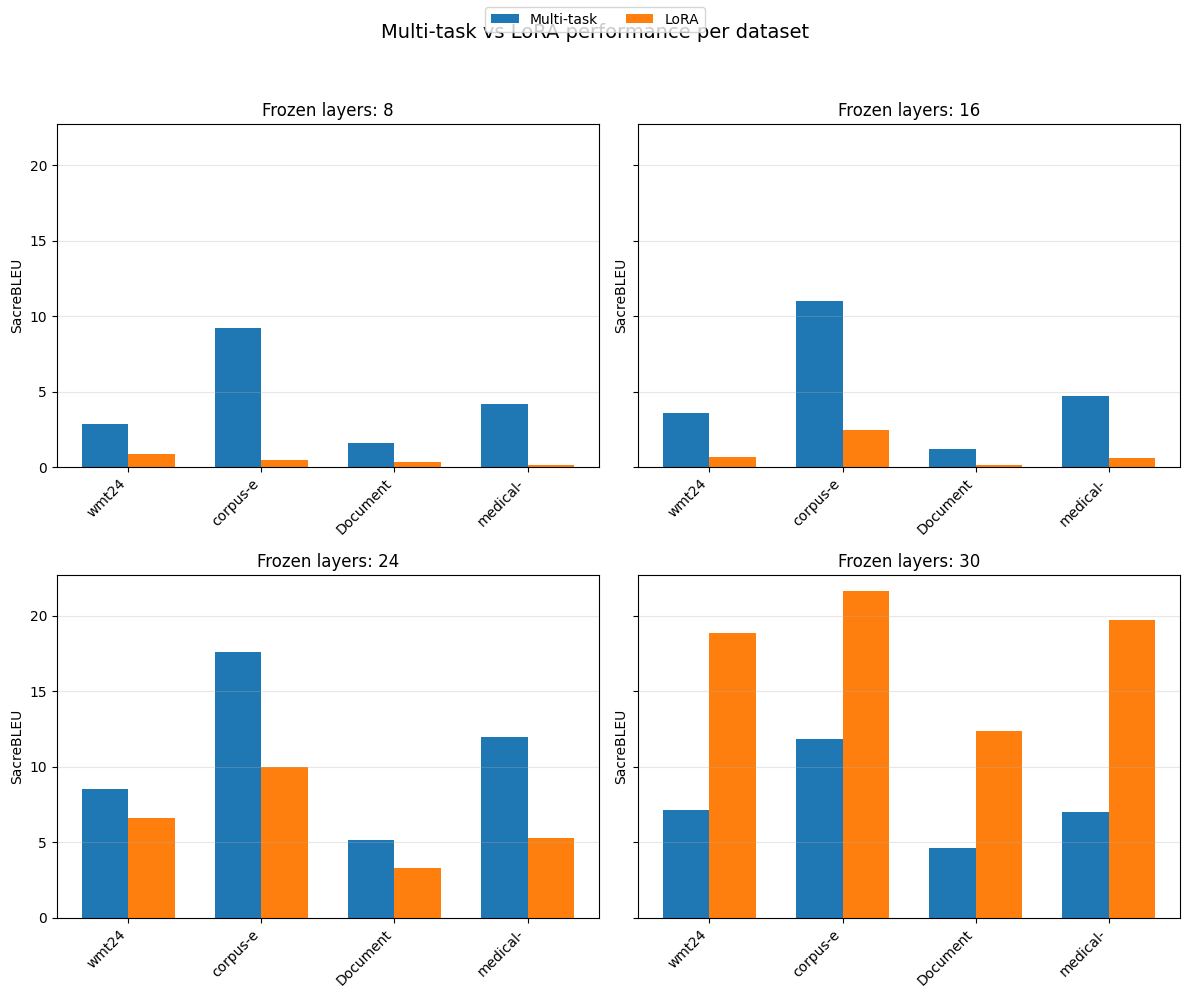

In [7]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10), sharey=True)
axes = axes.flatten()

layers = sorted(results['multi-task'])
width = 0.35
legend_handles = None

for ax, layer in zip(axes, layers):
    datasets = [
        ds for ds in results['multi-task'][layer]
        if ds != 'average' and ds in results['lora'][layer] and ds != 'all'
    ]
    x = range(len(datasets))
    multi_scores = [results['multi-task'][layer][ds] for ds in datasets]
    lora_scores = [results['lora'][layer][ds] for ds in datasets]

    bars_multi = ax.bar([i - width / 2 for i in x], multi_scores, width=width, label="Multi-task")
    bars_lora = ax.bar([i + width / 2 for i in x], lora_scores, width=width, label="LoRA")

    if legend_handles is None:
        legend_handles = (bars_multi[0], bars_lora[0])

    ax.set_title(f"Frozen layers: {layer}")
    ax.set_xticks(list(x))
    ax.set_xticklabels([ds[:8] for ds in datasets], rotation=45, ha="right")
    ax.set_ylabel("SacreBLEU")
    ax.grid(axis="y", alpha=0.3)

for ax in axes[len(layers):]:
    ax.axis("off")

fig.suptitle("Multi-task vs LoRA performance per dataset", fontsize=14)
fig.legend(legend_handles, ["Multi-task", "LoRA"], loc="upper center", ncol=2)
fig.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

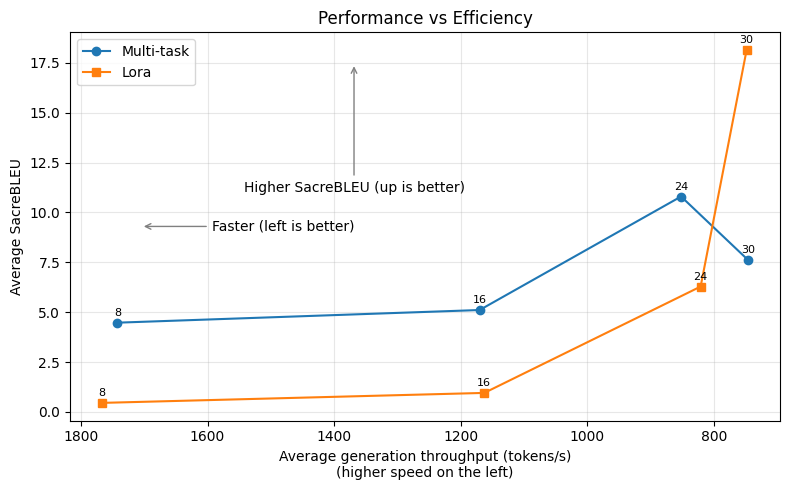

In [8]:
plt.figure(figsize=(8, 5))

styles = {"multi-task": {"color": "tab:blue", "marker": "o"},
          "lora": {"color": "tab:orange", "marker": "s"}}

for method, style in styles.items():
    layers = sorted(results[method])
    throughputs, averages_plot, layer_labels = [], [], []
    for layer in layers:
        if layer not in speed[method]:
            continue
        throughputs.append(speed[method][layer])
        averages_plot.append(results[method][layer]["average"])
        layer_labels.append(layer)

    plt.plot(throughputs, averages_plot, label=method.capitalize(),
             marker=style["marker"], color=style["color"])
    for t, s, layer in zip(throughputs, averages_plot, layer_labels):
        plt.annotate(f"{layer}", (t, s), textcoords="offset points",
                     xytext=(0, 5), ha="center", fontsize=8)

ax = plt.gca()
ax.annotate("Faster (left is better)", xy=(0.1, 0.5), xytext=(0.3, 0.5),
            xycoords="axes fraction", textcoords="axes fraction",
            arrowprops=dict(arrowstyle="->", color="gray"), ha="center", va="center")
ax.annotate("Higher SacreBLEU (up is better)", xy=(0.4, 0.92), xytext=(0.4, 0.6),
            xycoords="axes fraction", textcoords="axes fraction",
            arrowprops=dict(arrowstyle="->", color="gray"), ha="center", va="center")

plt.gca().invert_xaxis()
plt.title("Performance vs Efficiency")
plt.xlabel("Average generation throughput (tokens/s)\n(higher speed on the left)")
plt.ylabel("Average SacreBLEU")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

In [9]:
aug_results = results

In [19]:
results = {}
results['multi-task'] = {}
for frozen_layers in [6, 14, 22, 28]:
    name = result_naming.format(
        method="leobitz_MultiTask",
        frozen_layers=frozen_layers,
        task_layers=2,
        aug_size=0.0,
        bf16=0,
        temp=0.0,
        top_p=1.0
    )
    path = os.path.join(result_dir, name)
    vals = json.loads(open(path, "r").read())
    frozen_layers = frozen_layers + 2
    results['multi-task'][frozen_layers]= {}
    for dataset_name in vals.keys():
        if 'scientific_papers_en_es' in dataset_name or 'all' in dataset_name:
            continue
        results['multi-task'][frozen_layers][dataset_name] = vals[dataset_name]['sacrebleu']
    results['multi-task'][frozen_layers]['average'] = sum(results['multi-task'][frozen_layers].values()) / len(results['multi-task'][frozen_layers])

results['lora'] = {}
for frozen_layers in [8, 16, 24, 30]:
    name = result_naming.format(
        method="leobitz_LoRA",
        frozen_layers=frozen_layers,
        task_layers=0,
        aug_size=0.0,
        bf16=1,
        temp=0.0,
        top_p=1.0
    )
    path = os.path.join(result_dir, name)
    vals = json.loads(open(path, "r").read())
    results['lora'][frozen_layers]= {}
    for dataset_name in vals.keys():
        if 'scientific_papers_en_es' in dataset_name or 'all' in dataset_name:
            continue
        results['lora'][frozen_layers][dataset_name] = vals[dataset_name]['sacrebleu']
    results['lora'][frozen_layers]['average'] = sum(results['lora'][frozen_layers].values()) / len(results['lora'][frozen_layers])

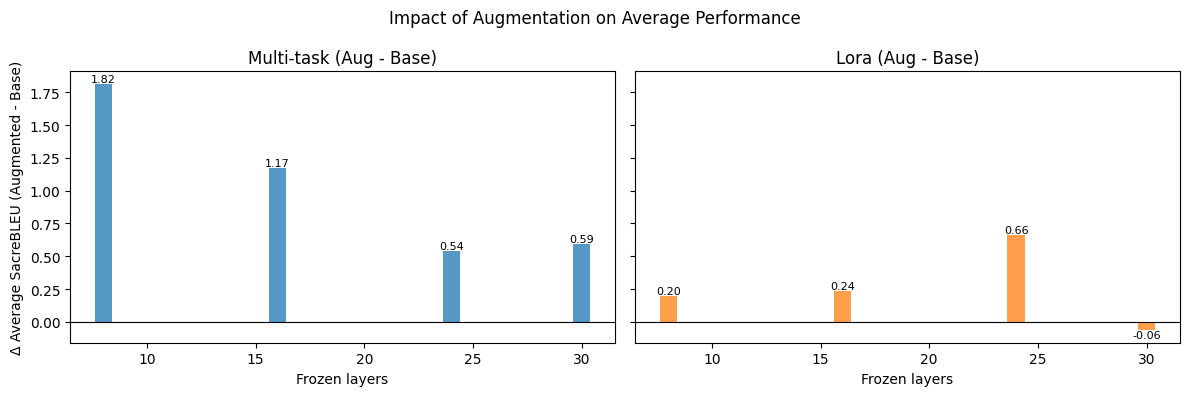

In [20]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

for ax, method, color in zip(
    axes, ["multi-task", "lora"], ["tab:blue", "tab:orange"]
):
    layers = sorted(results[method])
    method_result = results[method][layer]
    deltas = [
        aug_results[method][layer]["average"] - results[method][layer]["average"]
        for layer in layers
    ]

    bars = ax.bar(layers, deltas, color=color, alpha=0.75)
    ax.axhline(0, color="black", linewidth=0.8)
    ax.set_title(f"{method.capitalize()} (Aug - Base)")
    ax.set_xlabel("Frozen layers")

    for bar, delta in zip(bars, deltas):
        y = bar.get_height()
        va = "bottom" if y >= 0 else "top"
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            y,
            f"{delta:.2f}",
            ha="center",
            va=va,
            fontsize=8,
            color="black",
        )

axes[0].set_ylabel("Δ Average SacreBLEU (Augmented - Base)")
fig.suptitle("Impact of Augmentation on Average Performance")
plt.tight_layout()
plt.show()

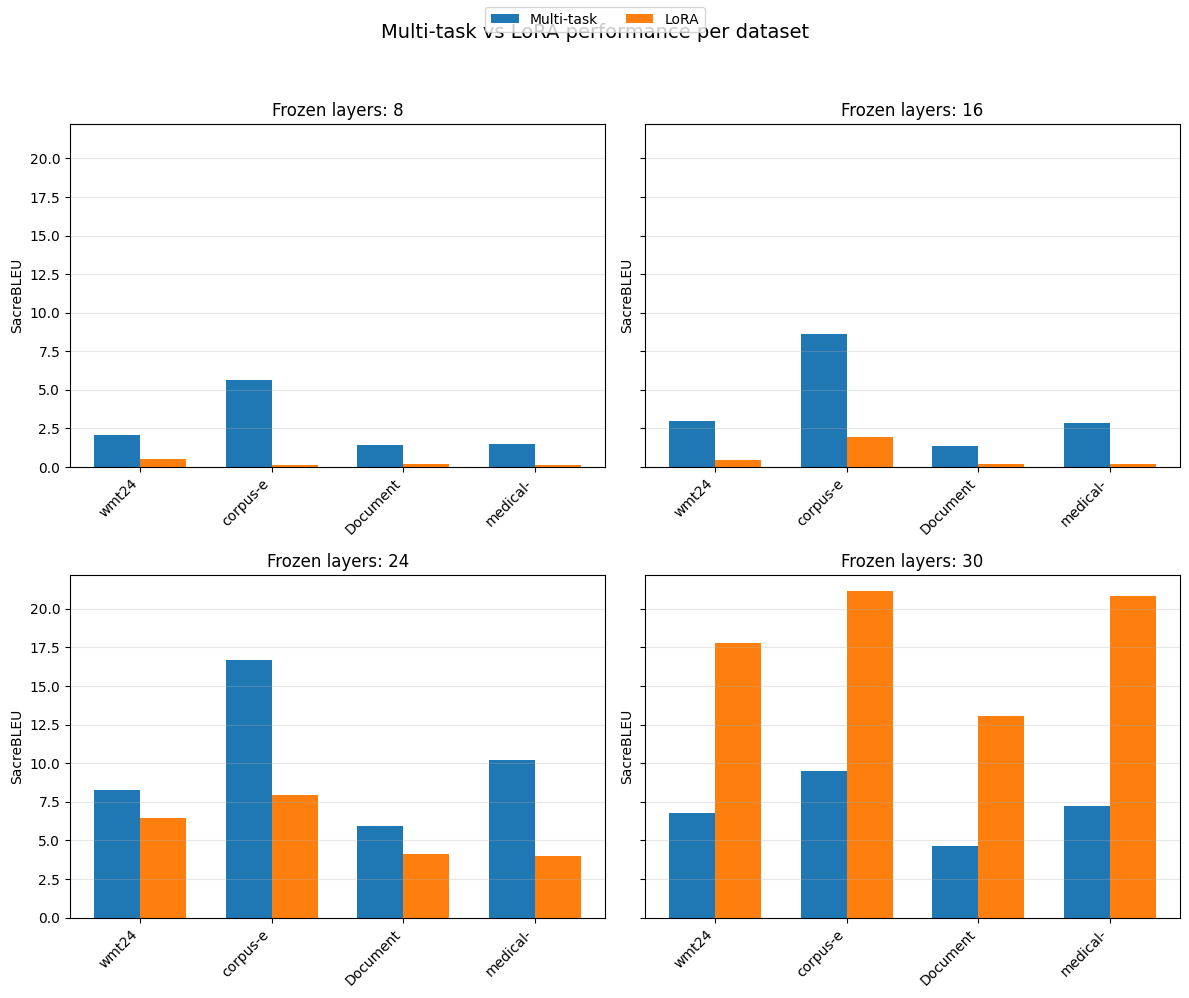

In [21]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10), sharey=True)
axes = axes.flatten()

layers = sorted(results['multi-task'])
width = 0.35
legend_handles = None

for ax, layer in zip(axes, layers):
    datasets = [
        ds for ds in results['multi-task'][layer]
        if ds != 'average' and ds in results['lora'][layer] and ds != 'all'
    ]
    x = range(len(datasets))
    multi_scores = [results['multi-task'][layer][ds] for ds in datasets]
    lora_scores = [results['lora'][layer][ds] for ds in datasets]

    bars_multi = ax.bar([i - width / 2 for i in x], multi_scores, width=width, label="Multi-task")
    bars_lora = ax.bar([i + width / 2 for i in x], lora_scores, width=width, label="LoRA")

    if legend_handles is None:
        legend_handles = (bars_multi[0], bars_lora[0])

    ax.set_title(f"Frozen layers: {layer}")
    ax.set_xticks(list(x))
    ax.set_xticklabels([ds[:8] for ds in datasets], rotation=45, ha="right")
    ax.set_ylabel("SacreBLEU")
    ax.grid(axis="y", alpha=0.3)

for ax in axes[len(layers):]:
    ax.axis("off")

fig.suptitle("Multi-task vs LoRA performance per dataset", fontsize=14)
fig.legend(legend_handles, ["Multi-task", "LoRA"], loc="upper center", ncol=2)
fig.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

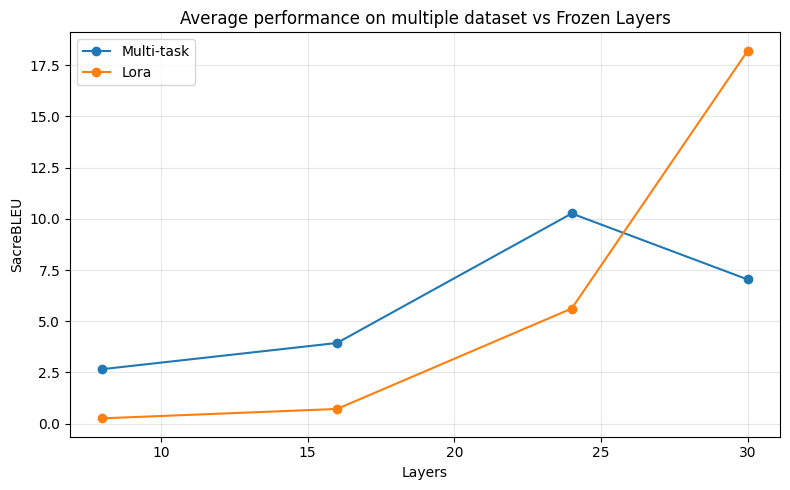

In [22]:
plt.figure(figsize=(8, 5))
for method in ("multi-task", "lora"):
    frozen_order = sorted(results[method])
    scores = [results[method][layers]['average'] for layers in frozen_order]
    plt.plot(frozen_order, scores, marker="o", label=method.capitalize())

plt.title(f"Average performance on multiple dataset vs Frozen Layers")
plt.xlabel("Layers")
plt.ylabel("SacreBLEU")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

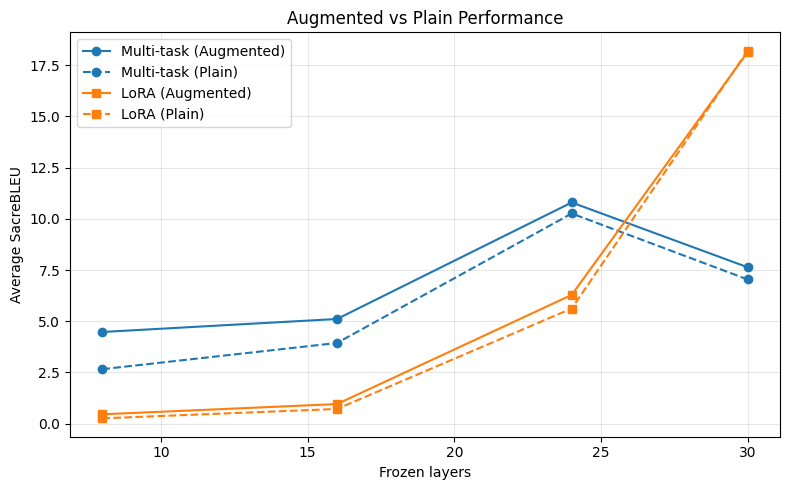

In [23]:
plt.figure(figsize=(8, 5))

layers_mt = sorted(results["multi-task"])
layers_lora = sorted(results["lora"])

plt.plot(
    layers_mt,
    [aug_results["multi-task"][layer]["average"] for layer in layers_mt],
    label="Multi-task (Augmented)",
    marker="o",
    linestyle="-",
    color="tab:blue",
)
plt.plot(
    layers_mt,
    [results["multi-task"][layer]["average"] for layer in layers_mt],
    label="Multi-task (Plain)",
    marker="o",
    linestyle="--",
    color="tab:blue",
)

plt.plot(
    layers_lora,
    [aug_results["lora"][layer]["average"] for layer in layers_lora],
    label="LoRA (Augmented)",
    marker="s",
    linestyle="-",
    color="tab:orange",
)
plt.plot(
    layers_lora,
    [results["lora"][layer]["average"] for layer in layers_lora],
    label="LoRA (Plain)",
    marker="s",
    linestyle="--",
    color="tab:orange",
)

plt.title("Augmented vs Plain Performance")
plt.xlabel("Frozen layers")
plt.ylabel("Average SacreBLEU")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

In [24]:
external_eval_files = {
    "EuroLLM-1.7B": "utter-project_EuroLLM-1.7B_T0.0_P1.0_evaluation.json",
    "HuggingFaceTB_SmolLM-135M": "HuggingFaceTB_SmolLM-135M_T0.0_P1.0_evaluation.json",
}

external_results = {}
for model_name, filename in external_eval_files.items():
    file_path = os.path.join(result_dir, filename)
    with open(file_path, "r", encoding="utf-8") as f:
        external_results[model_name] = json.load(f)

external_results

{'EuroLLM-1.7B': {'wmt24': {'sacrebleu': 24.8941535119711,
   'chrf': 47.74461377561422},
  'corpus-en-es': {'sacrebleu': 39.366477458932906, 'chrf': 63.98584737538753},
  'scientific_papers_en_es': {'sacrebleu': 1.872193081989142e-75,
   'chrf': 0.9445712390301736},
  'Document-Translation-en-es': {'sacrebleu': 48.7750404931816,
   'chrf': 72.19203502195029},
  'medical-translation-test-set': {'sacrebleu': 46.863630882217606,
   'chrf': 71.42881315402028},
  'all': {'sacrebleu': 0.028092536582748545, 'chrf': 14.709952583477326}},
 'HuggingFaceTB_SmolLM-135M': {'wmt24': {'sacrebleu': 0.7877982311274615,
   'chrf': 10.478044007696695},
  'corpus-en-es': {'sacrebleu': 0.6553188924419566,
   'chrf': 17.043483002620658},
  'scientific_papers_en_es': {'sacrebleu': 1.4439134366993884e-25,
   'chrf': 1.2363524638993775},
  'Document-Translation-en-es': {'sacrebleu': 2.057141204040324,
   'chrf': 24.066602952762633},
  'medical-translation-test-set': {'sacrebleu': 1.9703306805257286,
   'chrf'

In [16]:
layer = 30

comparison_records = []
labels = {"multi-task": "Multi-task", "lora": "LoRA"}

dataset_set = set()
for method in labels:
    for store in (results, aug_results):
        layer_scores = store.get(method, {}).get(layer, {})
        dataset_set.update(ds for ds in layer_scores if ds not in {"average", "all"})
for metrics in external_results.values():
    dataset_set.update(ds for ds in metrics if ds != "all")

dataset_order = sorted(dataset_set)
dataset_categories = dataset_order + ["Average (excl. all)"]

def add_variant_records(model_label, variant_label, score_mapping):
    if not score_mapping:
        return
    collected_scores = []
    for ds in dataset_order:
        if ds in score_mapping:
            score = score_mapping[ds]
            comparison_records.append(
                {"Model": model_label, "Variant": variant_label, "Dataset": ds, "Average SacreBLEU": score}
            )
            collected_scores.append(score)
    if collected_scores:
        avg_score = sum(collected_scores) / len(collected_scores)
        comparison_records.append(
            {
                "Model": model_label,
                "Variant": variant_label,
                "Dataset": "Average (excl. all)",
                "Average SacreBLEU": avg_score,
            }
        )

for method, label in labels.items():
    if method == 'multi-task':
        layer = 24
    else:
        layer = 30
    plain_scores = {ds: score for ds, score in results.get(method, {}).get(layer, {}).items() if ds not in {"average", "all"}}
    aug_scores = {ds: score for ds, score in aug_results.get(method, {}).get(layer, {}).items() if ds not in {"average", "all"}}
    add_variant_records(label, "Plain", plain_scores)
    add_variant_records(label, "Augmented", aug_scores)

for model_name, metrics in external_results.items():
    external_scores = {ds: vals["sacrebleu"] for ds, vals in metrics.items() if ds != "all"}
    add_variant_records(model_name, "External", external_scores)

comparison_df = pandas.DataFrame(comparison_records)
comparison_df["Dataset"] = pandas.Categorical(
    comparison_df["Dataset"], categories=dataset_categories, ordered=True
)
comparison_df = comparison_df.sort_values(["Dataset", "Average SacreBLEU"], ascending=[True, False]).reset_index(drop=True)

print(f"Layer {layer} comparison vs external baselines (higher is better):")
for dataset in dataset_categories:
    subset = comparison_df[comparison_df["Dataset"] == dataset]
    if subset.empty:
        continue
    header = "Average (excluding 'all')" if dataset == "Average (excl. all)" else dataset
    print(f"\n{header}:")
    for _, row in subset.iterrows():
        print(f"  {row['Model']} ({row['Variant']}): {row['Average SacreBLEU']:.2f}")

Layer 30 comparison vs external baselines (higher is better):

Document-Translation-en-es:
  EuroLLM-1.7B (External): 48.78
  LoRA (Plain): 12.35
  LoRA (Augmented): 12.35
  Multi-task (Plain): 5.15
  Multi-task (Augmented): 5.15
  HuggingFaceTB_SmolLM-135M (External): 2.06

corpus-en-es:
  EuroLLM-1.7B (External): 39.37
  LoRA (Plain): 21.62
  LoRA (Augmented): 21.62
  Multi-task (Plain): 17.59
  Multi-task (Augmented): 17.59
  HuggingFaceTB_SmolLM-135M (External): 0.66

medical-translation-test-set:
  EuroLLM-1.7B (External): 46.86
  LoRA (Plain): 19.72
  LoRA (Augmented): 19.72
  Multi-task (Plain): 11.96
  Multi-task (Augmented): 11.96
  HuggingFaceTB_SmolLM-135M (External): 1.97

scientific_papers_en_es:
  HuggingFaceTB_SmolLM-135M (External): 0.00
  EuroLLM-1.7B (External): 0.00

wmt24:
  EuroLLM-1.7B (External): 24.89
  LoRA (Plain): 18.87
  LoRA (Augmented): 18.87
  Multi-task (Plain): 8.49
  Multi-task (Augmented): 8.49
  HuggingFaceTB_SmolLM-135M (External): 0.79

Average (ex

In [17]:
print(f"{'Model':<12}{'Layers':<8}{'Plain Avg':>12}{'Aug Avg':>12}")
print("-" * 44)

labels = {"multi-task": "Multi-task", "lora": "LoRA"}
for method, label in labels.items():
    for layer in sorted(results[method]):
        plain_avg = results[method][layer]["average"]
        aug_avg = aug_results[method].get(layer, {}).get("average")
        if aug_avg is None:
            continue
        print(f"{label:<12}{layer:<8}{plain_avg:>12.2f}{aug_avg:>12.2f}")



Model       Layers     Plain Avg     Aug Avg
--------------------------------------------
Multi-task  8               4.48        4.48
Multi-task  16              5.11        5.11
Multi-task  24             10.80       10.80
Multi-task  30              7.63        7.63
LoRA        8               0.46        0.46
LoRA        16              0.96        0.96
LoRA        24              6.29        6.29
LoRA        30             18.14       18.14
